In [1]:
import numpy as np
import cvxpy as cp
from sklearn.svm import OneClassSVM
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel

def tax_svm(X, nu):
    n = X.shape[0]
    R = cp.Variable(1)
    c = cp.Variable(2)
    eps = cp.Variable(n)

    objective = cp.Minimize(R + 1 / (nu * n) * cp.sum(eps))
    constraints = [
        eps >= 0,  
        R >= 0
    ]

    for i in range(n):
        constraints += [cp.norm(X[i] - c, 2) ** 2 <= R + eps[i]]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    radius = np.sqrt(R.value)
    center = c.value
    
    return radius, center


def hyperplane_svm(X, nu):
    ocsvm = OneClassSVM(kernel='linear', nu=nu)
    ocsvm.fit(X)
    
    return ocsvm

/Users/petre/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/var/folders/xv/w6vjg90x4pd72d9mbrnc1v6h0000gn/T/ipykernel_4589/2253414885.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


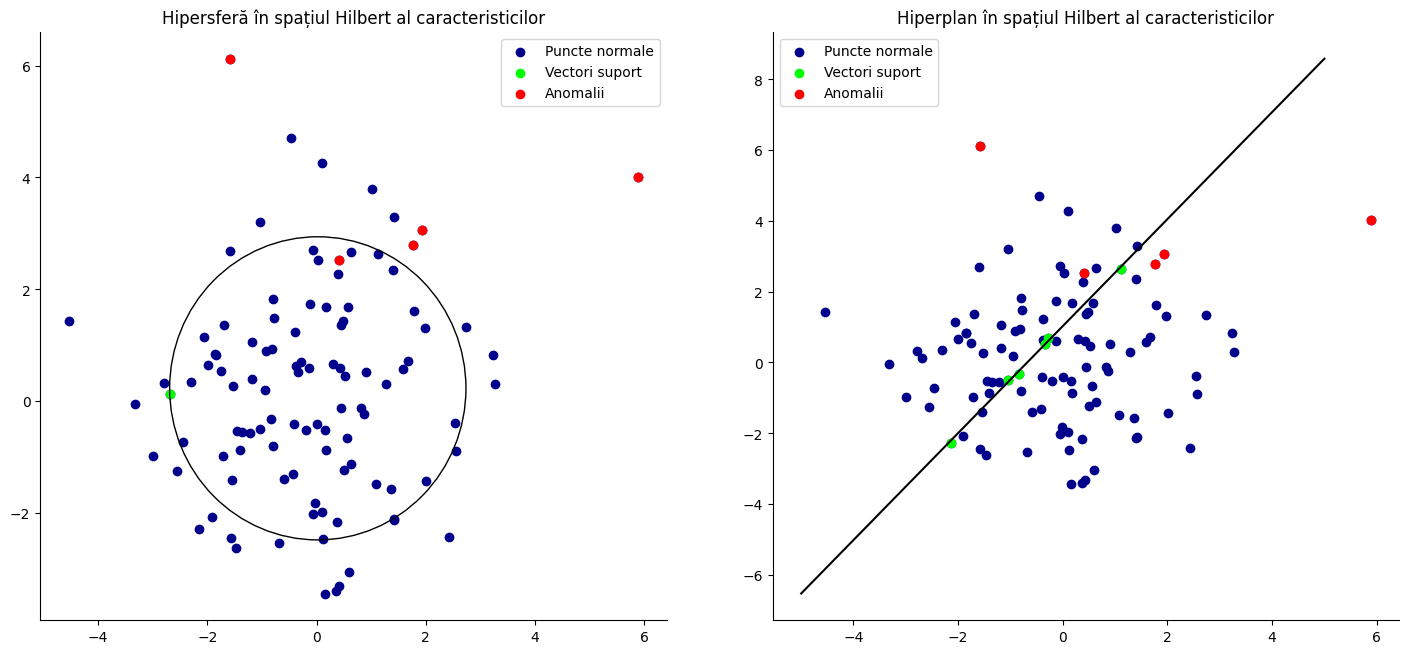

In [3]:
import matplotlib.pyplot as plt

np.random.seed(42)

normal_mean = [0, 0]
normal_cov = [[3, 0], [0, 3]]  # Increased covariance for more spread
num_normal_points = 100

normal_points = np.random.multivariate_normal(normal_mean, normal_cov, num_normal_points)

anomalous_mean = [3, 3]
anomalous_cov = [[3, 1], [1, 3]]  # Increased covariance for more spread
num_anomalous_points = 5

anomalous_points = np.random.multivariate_normal(anomalous_mean, anomalous_cov, num_anomalous_points)

X = np.vstack([normal_points, anomalous_points])

nu = 0.3

radius, center = tax_svm(X, nu)

clf = hyperplane_svm(X, nu)

# Plot the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

sphere_sv = []
for p in X:
    if np.abs((p[0] - center[0]) ** 2 + (p[1] - center[1]) ** 2 - radius ** 2) <= 10 ** -3:
        sphere_sv.append(p)

sphere_sv = np.array(sphere_sv)

plane_sv = []
for p in X:
    if np.abs(a * p[0] - (clf.intercept_[0]) / w[1] - p[1]) <= 10 ** -1:
        plane_sv.append(p)
        
plane_sv = np.array(plane_sv)

fig, ax = plt.subplots(1, 2)
ax[0].scatter(X[:, 0], X[:, 1], color='darkblue', label='Puncte normale')
ax[0].scatter(sphere_sv[:, 0], sphere_sv[:, 1], color='lime', label='Vectori suport')
ax[0].scatter(anomalous_points[:, 0], anomalous_points[:, 1], color='red', label='Anomalii')
circle = plt.Circle(center, radius, fill=False)
ax[0].add_patch(circle)
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set_title("Hipersferă în spațiul Hilbert al caracteristicilor")
ax[0].legend()

ax[1].scatter(X[:, 0], X[:, 1], color='darkblue', label='Puncte normale')
ax[1].scatter(plane_sv[:, 0], plane_sv[:, 1], color='lime', label='Vectori suport')
ax[1].scatter(anomalous_points[:, 0], anomalous_points[:, 1], color='red', label='Anomalii')
ax[1].plot(xx, yy, 'k-')
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_title("Hiperplan în spațiul Hilbert al caracteristicilor")
ax[1].legend()

fig.tight_layout()
fig.set_figheight(7)
fig.set_figwidth(15)
fig.savefig("cvx_ocsvm_figures.pdf")
fig.show()

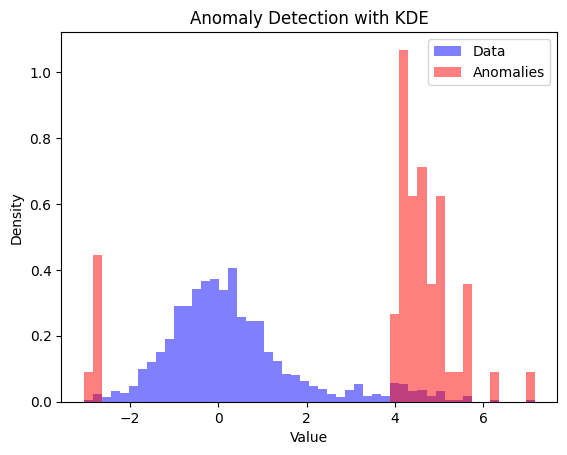

In [49]:
from sklearn.neighbors import KernelDensity

# Generate some example data (1D for simplicity)
np.random.seed(0)
data = np.concatenate([np.random.normal(0, 1, 1000), np.random.normal(4, 1, 100)])

# Fit Kernel Density Estimation
kde = KernelDensity(bandwidth=0.75, kernel='gaussian')
kde.fit(data[:, None])

# Compute log density values for each data point
log_density = kde.score_samples(data[:, None])

# Set a threshold for anomaly detection
threshold = np.percentile(log_density, 5)  # for example, consider the bottom 5% as anomalies

# Identify anomalies
anomalies = data[log_density < threshold]

# Plot the data and highlight anomalies
plt.hist(data, bins=50, density=True, alpha=0.5, color='blue', label='Data')
plt.hist(anomalies, bins=50, density=True, alpha=0.5, color='red', label='Anomalies')
plt.legend()
plt.title('Anomaly Detection with KDE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()
